In [1]:
import pymongo
from pymongo import MongoClient
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import pandas as pd
import folium

In [2]:
client = MongoClient ()
db = client.fit3182_assignment_db

merged_stream = db.merged_stream


In [3]:
merged_stream_data = merged_stream.find()
merged_stream_data = list(merged_stream_data)
merged_stream_data = pd.DataFrame(merged_stream_data)

merged_stream_data['datetime'] = pd.to_datetime(merged_stream_data['datetime'])
merged_stream_data['air_temperature_celcius'] = pd.to_numeric(merged_stream_data['air_temperature_celcius'])

merged_stream_data.head()

,_id,latitude,longitude,air_temperature_celcius,relative_humidity,windspeed_knots,max_wind_speed,precipitation,GHI_w/m2,datetime,key,encode_location,Hotspot,fire_cause
0,62877f0cc240079cf28c52fd,-37.9540,143.9180,20,59.7,8.6,15.9,0.01G,158,2021-12-28 04:16:51,Producer01,r1q,"[{'latitude': -37.5318, 'longitude': 143.4615,...",other
1,62877f14c240079cf28c52fe,-37.6745,142.9848,15,44.5,10.2,14.0,0.00G,134,2021-12-28 04:17:01,Producer01,r1m,"[{'latitude': -37.446, 'longitude': 142.8978, ...",other
2,62877f14c240079cf28c52ff,-38.5270,143.4930,19,51.5,10.2,20.0,0.00I,161,2021-12-28 04:17:11,Producer01,r1n,"[{'latitude': -38.0171, 'longitude': 143.7532,...",other
3,62877f14c240079cf28c5300,-35.9530,141.0780,12,47.2,8.8,15.0,0.00G,105,2021-12-28 04:17:21,Producer01,r1s,"[{'latitude': -36.4399, 'longitude': 141.0914,...",other
4,62877f14c240079cf28c5301,-37.8560,143.4160,15,53.7,6.8,11.1,0.51G,125,2021-12-28 04:17:31,Producer01,r1m,"[{'latitude': -37.446, 'longitude': 142.8978, ...",other


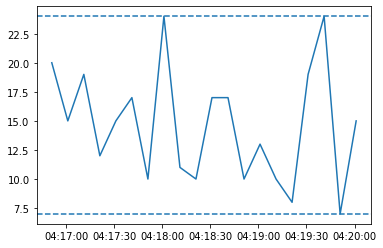

In [4]:
# Task 2(1) 
x = merged_stream_data['datetime']
y = merged_stream_data['air_temperature_celcius']

# sort the data in prior for plotting
# if not then matplotlib will expect the coordinates are in order
x1,y1 = zip(*sorted(zip(x,y),key = lambda x : x[0]))

plt.plot(x1,y1)
plt.axhline(merged_stream_data['air_temperature_celcius'].max(), linestyle = "--")
plt.axhline(merged_stream_data['air_temperature_celcius'].min(), linestyle = "--")

96.0


<AxesSubplot:xlabel='datetime'>

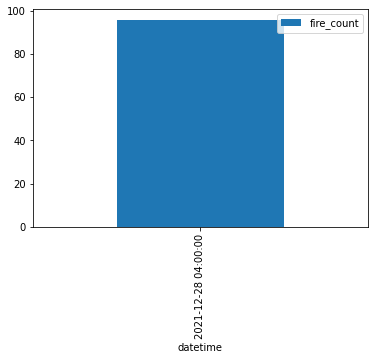

In [5]:
# Task 2 Q(2)(A)


merged_stream_data = merged_stream.find()
merged_stream_data = list(merged_stream_data)
merged_stream_data = pd.DataFrame(merged_stream_data)
total = 0
merged_stream_data['datetime'] = pd.to_datetime(merged_stream_data['datetime'])
hotspot = merged_stream_data['Hotspot']

for i in range(len(hotspot)):
    if type(hotspot[i]) == list:
        merged_stream_data.loc[i,'fire_count'] = len(hotspot[i])


temp = merged_stream_data.groupby([pd.Grouper(key = 'datetime', freq='H')])
res = temp['fire_count'].sum()

res = pd.DataFrame(res)
res.plot.bar()

In [6]:
# Task 2 Q(2)(B)

from pymongo import MongoClient


# Preparing the data for plotting
natural = []
natural_air_temp = []
natural_sur_temp = []
natural_hum = []
natural_conf = []
natural_col = []

other = []
other_air_temp = []
other_sur_temp = []
other_hum = []
other_conf = []
other_col = []

# Looping through all the data
for row in merged_stream.find():
    # Checking if the parking spot is available
    if row['fire_cause'] == 'natural':
        # Adding the latitude and longitude to the list of hotspots
        rows = row['Hotspot']
        for fires in rows:
            natural.append( (float(fires['latitude']), float(fires['longitude'])) )
            natural_air_temp.append(row['air_temperature_celcius'])
            natural_hum.append(row['relative_humidity'])
            natural_sur_temp.append(fires['surface_temperature_celcius'])
            natural_conf.append(fires['confidence'])
            natural_col.append("blue")
            
    if row['fire_cause'] == 'other':
        # Adding the latitude and longitude to the list of hotspots
        rows = row['Hotspot']
        for fires in rows:
            other.append( (float(fires['latitude']), float(fires['longitude'])) )
            other_air_temp.append(row['air_temperature_celcius'])
            other_hum.append(row['relative_humidity'])
            other_sur_temp.append(fires['surface_temperature_celcius'])
            other_conf.append(fires['confidence'])
            other_col.append("red")




In [7]:
hotspot_map = folium.Map(location=[-37.634, 149.237], zoom_start=5)

In [8]:
locs = natural + other
air_temp = natural_air_temp + other_air_temp
sur_temp = natural_sur_temp + other_sur_temp
hum = natural_hum + other_hum 
conf = natural_conf + other_conf
col = natural_col + other_col


for i in range(len(locs)):
    loc = locs[i]
    if col[i] == "blue" :
        folium.Marker(location=loc, tooltip = ("air_temperature : " + str(air_temp[i]) +" \n surface_temperature : " + str(sur_temp[i]) + " \n humidity : " + str(hum[i]) + "\n confidence : " + str(conf[i])),popup=f"latitude={loc[0]:.2f}, longitude={loc[1]:.2f}", icon=folium.Icon(color = "blue", )).add_to(hotspot_map)
    if col[i] == "red" :
        folium.Marker(location=loc, tooltip = ("air_temperature : " + str(air_temp[i]) +" \n surface_temperature : " + str(sur_temp[i]) + " \n humidity : " + str(hum[i]) + "\n confidence : " + str(conf[i])),popup=f"latitude={loc[0]:.2f}, longitude={loc[1]:.2f}", icon=folium.Icon(color = "red", )).add_to(hotspot_map)


In [9]:
hotspot_map